# Accuracy 81%

In [1]:
import os
import time
import shutil
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve\
,auc
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

tensorflow version: 2.7.0


In [2]:
tqdm_notebook.pandas()

## Import files and labels

In [3]:
train_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])
test_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])

In [4]:
path = 'dataset_clips'
for filename in os.listdir(f'{path}/train/true/'):
    new_row = {'full_path': f'{path}/train/true/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/train/self_collect_true/'):
    new_row = {'full_path': f'{path}/train/self_collect_true/', 'filename': filename, 'is_train': True, 'is_augmented': True, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)
    
for filename in os.listdir(f'{path}/train/false/'):
    new_row = {'full_path': f'{path}/train/false/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 0}
    train_df = train_df.append(new_row, ignore_index = True)

In [5]:
path = 'dataset_clips'
for filename in os.listdir(f'{path}/test/true/'):
    new_row = {'full_path': f'{path}/test/true/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 1}
    test_df = test_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/test/false/'):
    new_row = {'full_path': f'{path}/test/false/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 0}
    test_df = test_df.append(new_row, ignore_index = True)

## Undersampling

In [25]:
def undersampling_class(df, label_column, to_reduce_class, sample_number):
    true_df = df[df[label_column]==1]
    false_df = df[df[label_column]==0]
    
    if to_reduce_class == 0:
        false_df = false_df.sample(n=sample_number)
    else:
        true_df = true_df.sample(n=sample_number)
    
    return pd.concat([true_df, false_df], axis=0)

In [27]:
train_df = undersampling_class(train_df, 'um_label', 0, 6_000)
test_df = undersampling_class(test_df, 'um_label', 0, 1500)

In [28]:
train_df.value_counts(['um_label'])

um_label
0           6000
1           5034
dtype: int64

In [29]:
test_df.value_counts(['um_label'])

um_label
0           1500
1           1200
dtype: int64

## Convert to MFCC

In [31]:
def extract_mfcc(df):
    try:
        folder_name = 'clips'
        audio, sr = librosa.load(f'{df["full_path"]}{df["filename"]}', sr=16000)
        mfcc = librosa.feature.mfcc(audio, sr, n_mfcc=13)
        return mfcc
    except:
        return None

In [32]:
%%time
train_df['mfcc'] = train_df.progress_apply(extract_mfcc, axis=1)
test_df['mfcc'] = test_df.progress_apply(extract_mfcc, axis=1)

  0%|          | 0/11034 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

CPU times: total: 2min 21s
Wall time: 2min 45s


In [33]:
X_train = np.stack(train_df['mfcc'].to_numpy())
y_train = train_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

X_test = np.stack(test_df['mfcc'].to_numpy())
y_test = test_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

In [34]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(13, 94, 1)

# Train model

In [35]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (2,2), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [36]:
model = create_cnn_model(input_shape)

In [37]:
adam_optimizer = Adam(learning_rate=0.00005)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

In [38]:
%%time
num_epochs = 100
num_batch_size = 64

model_checkpoint = ModelCheckpoint(filepath='models/v7 (with_self_collected_data_undersampled).hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

history = model.fit(X_train, 
          y_train, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(X_test, y_test), 
          callbacks=[model_checkpoint, early_stop], 
          verbose=1)

Epoch 1/100
172/173 [============================>.] - ETA: 0s - loss: 0.8978 - accuracy: 0.5172
Epoch 00001: val_loss improved from inf to 0.68922, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 7s 36ms/step - loss: 0.8975 - accuracy: 0.5173 - val_loss: 0.6892 - val_accuracy: 0.5430
Epoch 2/100
171/173 [============================>.] - ETA: 0s - loss: 0.7909 - accuracy: 0.5449
Epoch 00002: val_loss improved from 0.68922 to 0.66245, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 6s 34ms/step - loss: 0.7907 - accuracy: 0.5445 - val_loss: 0.6624 - val_accuracy: 0.6026
Epoch 3/100
171/173 [============================>.] - ETA: 0s - loss: 0.7412 - accuracy: 0.5637
Epoch 00003: val_loss improved from 0.66245 to 0.64630, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 6s 34ms/step - loss: 0.74

Epoch 24/100
171/173 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.7928
Epoch 00024: val_loss improved from 0.46975 to 0.46507, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 6s 35ms/step - loss: 0.4510 - accuracy: 0.7925 - val_loss: 0.4651 - val_accuracy: 0.7859
Epoch 25/100
171/173 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.7945
Epoch 00025: val_loss improved from 0.46507 to 0.46330, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 6s 37ms/step - loss: 0.4432 - accuracy: 0.7949 - val_loss: 0.4633 - val_accuracy: 0.7896
Epoch 26/100
171/173 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.8008
Epoch 00026: val_loss improved from 0.46330 to 0.46041, saving model to models\v7 (with_self_collected_data_undersampled).hdf5
173/173 [==============================] - 6s 37ms/step - los

Epoch 00050: early stopping
CPU times: total: 37min 58s
Wall time: 5min 6s


# Test Model

In [17]:
model = create_cnn_model(input_shape)

model.load_weights('models/v7 (with_self_collected_data_undersampled).hdf5')

In [39]:
def test_thresholds(X, y):
    fpr, tpr, thresholds = roc_curve(y, model.predict(X))
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
    possible_thresholds = np.linspace(0, 1, num=20)
    df_metrics = pd.DataFrame()
    for threshold in possible_thresholds:
        y_pred = (model.predict(X) > threshold).astype("int32")
        df_metrics = df_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }, ignore_index=True)
        
    sns.lineplot(data=df_metrics.set_index('threshold'), palette="tab10", linewidth=2.5)
    
    return df_metrics

In [42]:
y_pred = (model.predict(X_test) > 0.2).astype("int32")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

Accuracy: 0.7503703703703704
f1 score: 0.7579022988505747


array([[ 971,  529],
       [ 145, 1055]], dtype=int64)

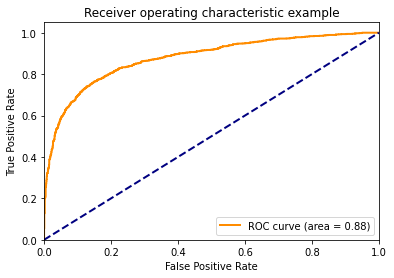

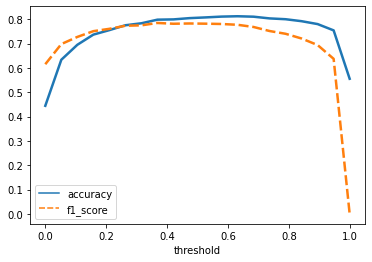

In [40]:
df_metrics = test_thresholds(X_test, y_test)

In [41]:
df_metrics.sort_values('accuracy', ascending=False)

,accuracy,f1_score,threshold
12,0.812593,0.777485,0.631579
11,0.811111,0.780739,0.578947
13,0.810741,0.768464,0.684211
10,0.807778,0.782024,0.526316
9,0.804815,0.782859,0.473684
14,0.803704,0.751873,0.736842
15,0.800370,0.740491,0.789474
8,0.799630,0.781767,0.421053
7,0.798519,0.784980,0.368421
16,0.792222,0.721034,0.842105
